In [1]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
# from sklearn import datasets


6


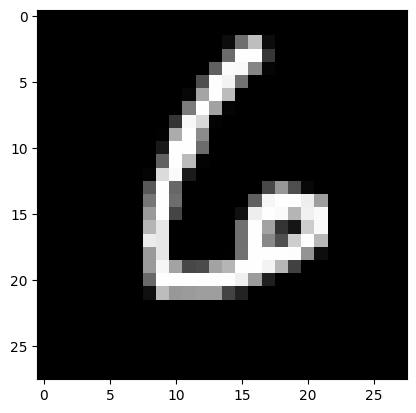

In [2]:
from torchvision.datasets import MNIST

common_transform = transforms.Compose([
    transforms.ToTensor(),                 # -> [0,1], [C,H,W]
    transforms.Normalize((0.5,), (0.5,))   # all datasets normalized the same
])


mnist_train = MNIST(root="./data", train=True,  download=True, transform=common_transform)
mnist_test  = MNIST(root="./data", train=False, download=True, transform=common_transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_loader  = DataLoader(mnist_test, batch_size=64, shuffle=False)

img_idx = 50002
img_0 = mnist_train.data[img_idx]
img_0_label = mnist_train.targets[img_idx].item()
print(img_0_label)
plt.imshow(img_0, cmap='gray')
plt.show()


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mloey1/ahdd1")

print("Path to dataset files:", path)

# !cp -r {path}/* .
# !ls

/Users/tensor/code/data_science_container/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/tensor/.cache/kagglehub/datasets/mloey1/ahdd1/versions/3


In [4]:
# Paths
base = Path("data")
kaggle_path = base / "kaggle" / "mloey1" / "ahdd1"
kaggle_path.mkdir(parents=True, exist_ok=True)

print("Copying files to:", kaggle_path)
!cp -r {path}/* {kaggle_path}

Copying files to: data/kaggle/mloey1/ahdd1


In [5]:


train_img_path = kaggle_path / "csvTrainImages 60k x 784.csv"
train_lbl_path = kaggle_path / "csvTrainLabel 60k x 1.csv"
test_img_path = kaggle_path / "csvTestImages 10k x 784.csv"
test_lbl_path = kaggle_path / "csvTestLabel 10k x 1.csv"

train_images = pd.read_csv(train_img_path, header=None).values.astype(np.uint8)
train_labels = pd.read_csv(train_lbl_path, header=None).values.astype(np.int64).flatten()

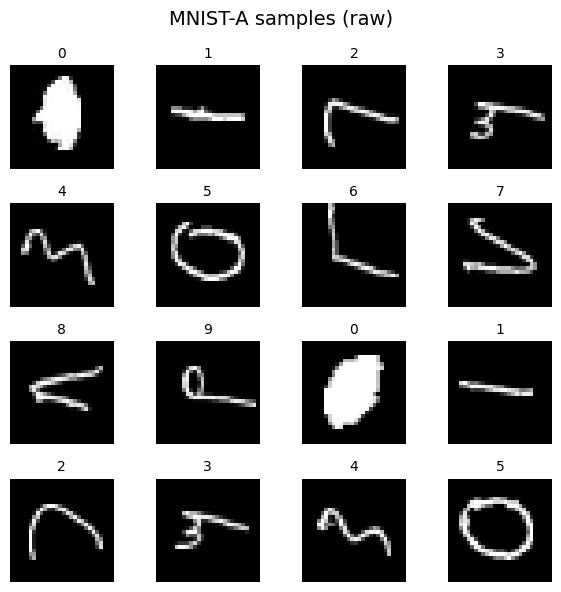

In [6]:

# Parameters you can tweak live
start_idx = 50000
num_images = 16      # must be a square number: 4, 9, 16, 25, ...
grid_size = int(np.sqrt(num_images))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    idx = start_idx + i
    img = train_images[idx].reshape(28, 28)
    label = train_labels[idx]

    ax.imshow(img, cmap="gray")
    ax.set_title(f"{label}", fontsize=10)
    ax.axis("off")

plt.suptitle("MNIST-A samples (raw)", fontsize=14)
plt.tight_layout()
plt.show()


In [7]:
from PIL import Image
from torch.utils.data import Dataset


class MNISTA_Dataset(Dataset):
    """Custom Dataset for MNIST-A (Arabic Handwritten Digits)"""
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx].reshape(28, 28)
        # Fix orientation: flip first, then rotate with k=3
        img = np.fliplr(img).copy()  # Horizontal flip
        img = np.rot90(img, k=1).copy()  # Rotate 90 degrees

        # Convert to PIL for transforms
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        # Convert to Python int to ensure proper DataLoader collation
        label = int(self.labels[idx])
        return img, label

In [8]:
# Load MNIST-A test data
test_images = pd.read_csv(test_img_path, header=None).values.astype(np.uint8)
test_labels = pd.read_csv(test_lbl_path, header=None).values.astype(np.int64).flatten()

# Create MNIST-A datasets with orientation fix applied
mnista_train = MNISTA_Dataset(train_images, train_labels, transform=common_transform)
mnista_test = MNISTA_Dataset(test_images, test_labels, transform=common_transform)

# Create MNIST-A dataloaders (same batch size as MNIST)
mnista_train_loader = DataLoader(mnista_train, batch_size=64, shuffle=True)
mnista_test_loader = DataLoader(mnista_test, batch_size=64, shuffle=False)

print(f"MNIST-A train: {len(mnista_train)} samples")
print(f"MNIST-A test:  {len(mnista_test)} samples")

MNIST-A train: 60000 samples
MNIST-A test:  10000 samples


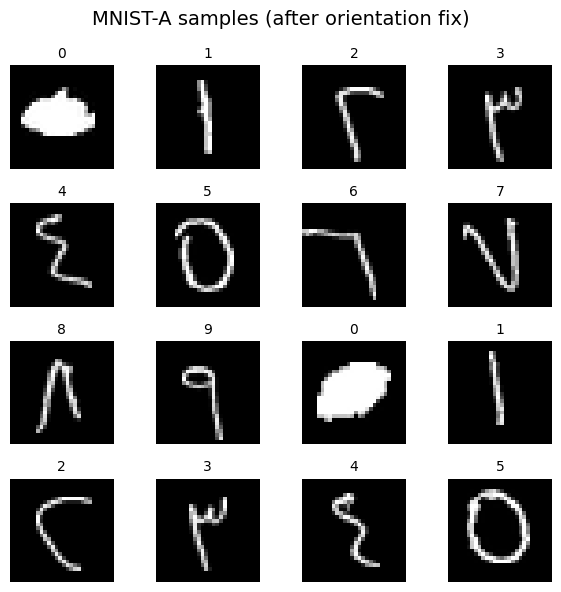

In [9]:
# Verify MNIST-A images are correctly oriented after applying the fix
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    img, label = mnista_train[50000 + i]
    # Denormalize for display: (x * 0.5) + 0.5 = x/2 + 0.5
    img_display = img.squeeze().numpy() * 0.5 + 0.5
    ax.imshow(img_display, cmap="gray")
    ax.set_title(f"{label}", fontsize=10)
    ax.axis("off")

plt.suptitle("MNIST-A samples (after orientation fix)", fontsize=14)
plt.tight_layout()
plt.show()

# Class exercise — Data correctness and responsibility

## Part 1

* What is wrong with these images?
* What needs to change so that the digits **match their labels** and can be used for training?
* **Apply the fix at the Dataset / DataLoader level**, not only for a single image. Your solution should apply consistently to all samples returned by the DataLoader.

* Verify your solution by displaying at least 8–16 images from the DataLoader.

*Important*:

The goal is not to “fix this picture”.
The goal is to ensure that **every image returned by the DataLoader is correct**, everywhere it is used.


**Why this matters (read carefully)**
* Fixing a single image is a demo.
* Fixing the Dataset is engineering.
* Models will happily train on incorrect data — they will not warn you.

### Answers: Data Correctness

**What is wrong with these images?**
The raw MNIST-A images are incorrectly oriented. They appear mirrored and rotated compared to how the digits should look. This is a common issue when datasets are exported from different coordinate systems or scanning orientations.

**What needs to change?**
The images need to be:
1. Horizontally flipped (`np.fliplr`)
2. Rotated 90 degrees (`np.rot90` with k=1)

**How was this fixed?**
The fix was applied at the Dataset level in `MNISTA_Dataset.__getitem__()`, ensuring every image returned by the DataLoader is correctly oriented. This is the proper engineering approach - not fixing individual images, but fixing the data pipeline itself.

In [10]:
from torch import nn


class CNNM(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # (B,16,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2),                 # (B,16,14,14)

            nn.Conv2d(16, 32, 3, padding=1), # (B,32,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2),                 # (B,32,7,7)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


## Class Exercise — Part 2: “When a working model suddenly doesn’t”

### Goal
Train a small CNN (CNNM) on **MNIST** only.  
Then evaluate it on **MNIST-A** **without any retraining**.

### What you should observe
- MNIST accuracy becomes high quickly.
- MNIST-A accuracy drops a lot (domain shift).
- Some digits fail more than others.
- The model can be confidently wrong.

### Rules
- Do **not** retrain on MNIST-A yet.
- Only swap the dataloader for evaluation.


In [11]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print("device:", device)

device: mps


## Training & evaluation utilities (provided)
You should already “know this”, so we’re giving you clean helpers to save time.


In [12]:
@torch.no_grad()
def evaluate(model, loader, max_batches=None):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    for b, (x, y) in enumerate(loader):
        if max_batches is not None and b >= max_batches:
            break

        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.numel()
        total_loss += loss.item() * y.size(0)

    avg_loss = total_loss / max(total, 1)
    acc = correct / max(total, 1)
    return avg_loss, acc


def train_one_epoch(model, loader, optimizer):
    model.train()
    criterion = nn.CrossEntropyLoss()

    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        # Note: non_blocking=True and set_to_none=True removed due to MPS backend bugs
        # that cause numerical instability and evaluation failures on Apple Silicon
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.numel()

    return running_loss / max(total, 1), correct / max(total, 1)

## Step 1 — Train CNNM on MNIST (short run)

We’ll train for a few epochs just to get a “working MNIST model”.


In [13]:
model = CNNM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = []
EPOCHS = 4  # keep short for class

t0 = time.time()
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, mnist_train_loader, optimizer)
    te_loss, te_acc = evaluate(model, mnist_test_loader)

    history.append((epoch, tr_loss, tr_acc, te_loss, te_acc))
    print(f"epoch {epoch:02d} | train loss={tr_loss:.4f} acc={tr_acc:.3f} | test loss={te_loss:.4f} acc={te_acc:.3f}")

print(f"\nTraining time: {time.time() - t0:.1f}s")


epoch 01 | train loss=0.3045 acc=0.905 | test loss=0.0654 acc=0.979
epoch 02 | train loss=0.0940 acc=0.972 | test loss=0.0513 acc=0.985
epoch 03 | train loss=0.0683 acc=0.980 | test loss=0.0412 acc=0.987
epoch 04 | train loss=0.0559 acc=0.983 | test loss=0.0375 acc=0.989

Training time: 19.1s


## Step 2 — The actual exercise: evaluate on MNIST-A **without retraining**

Do NOT change the model weights.  
Just evaluate the trained MNIST model on MNIST-A and compare.

**Important:**  
Poor performance on MNIST-A at this stage is expected and not a failure.


## Step 3 — Where does it fail? (per-class accuracy)

This helps you see which digits suffer most under domain shift.


## Class Exercise — Confusion Matrix (MNIST vs MNIST-A)

So far we compared **overall accuracy**.  
Now we want to understand **how** the model fails.

### Task
Compute and visualize a **confusion matrix** for:
- MNIST (model trained on MNIST, tested on MNIST)
- MNIST-A (same model, tested on MNIST-A)

### Reminder: what is a confusion matrix?
For a classification problem with 10 classes:
- Rows = **true labels**
- Columns = **predicted labels**
- Entry (i, j) = how many samples of class *i* were predicted as *j*

Perfect classifier → matrix is diagonal.

---

### Step 1 — Collect predictions and true labels

You need:
- all true labels from the test set
- all predicted labels from the model

Hints:
- use `model.eval()` and `torch.no_grad()`
- loop over the test DataLoader
- use `argmax(dim=1)` on model outputs
- move tensors to CPU before converting to NumPy

You should end up with two 1D arrays:
- `y_true`
- `y_pred`


### Step 2 — Compute the confusion matrix

Reminder options:
- `sklearn.metrics.confusion_matrix(y_true, y_pred)`
- OR build it manually using NumPy (counts in a 10×10 array)

Either approach is fine.

Make sure:
- shape is (10, 10)
- labels 0–9 are in the correct order


## (Hint) Confusion matrix helper — skeleton only

You may use this function signature **or write your own**.

Goal:
- iterate over a DataLoader
- collect true labels and predicted labels
- return a confusion matrix of shape (10, 10)

You decide how to implement the internals.


In [14]:
def compute_confusion_matrix(model, loader, num_classes=10):
    """
    Args:
        model: trained PyTorch model
        loader: DataLoader (MNIST or MNIST-A test set)
        num_classes: number of classes (default: 10)

    Returns:
        cm: NumPy array of shape (num_classes, num_classes)
            rows = true labels
            cols = predicted labels
    """
    model.eval()
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu()
            y = y.cpu()

            for t, p in zip(y, preds):
                cm[t.item(), p.item()] += 1

    return cm

### Step 3 — Visualize with matplotlib

Requirements:
- use `plt.imshow(...)`
- add a colorbar
- label axes:
  - x-axis: "Predicted label"
  - y-axis: "True label"
- add a title (MNIST or MNIST-A)

Optional (recommended):
- normalize rows so each row sums to 1
- annotate cells with values (especially useful)

Reminder:
- confusion matrices are *interpretable visual tools*, not just numbers


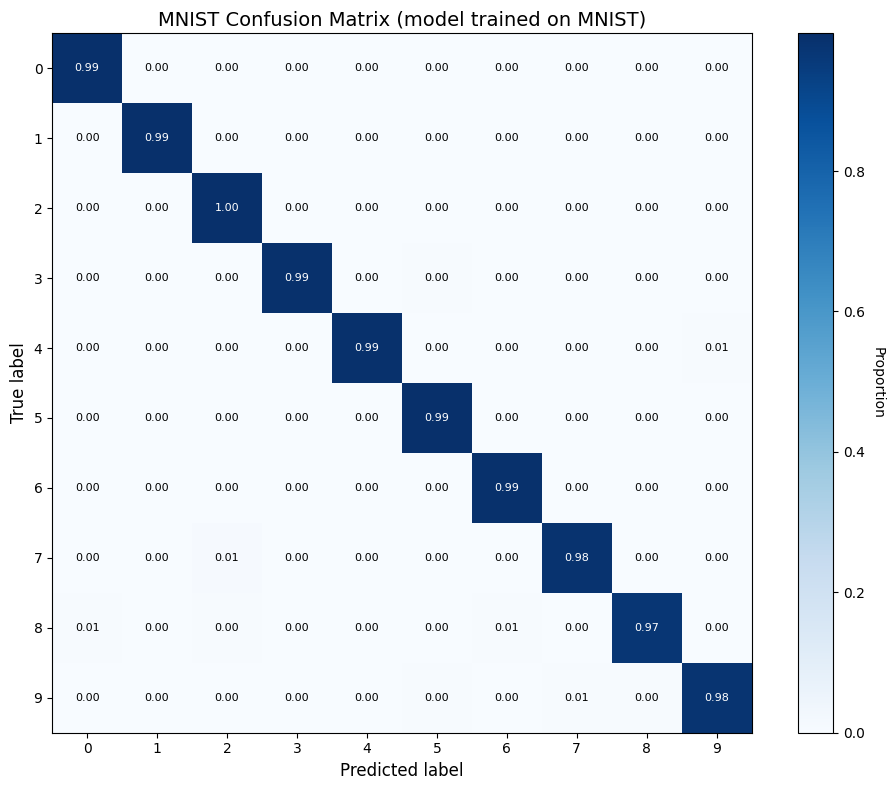

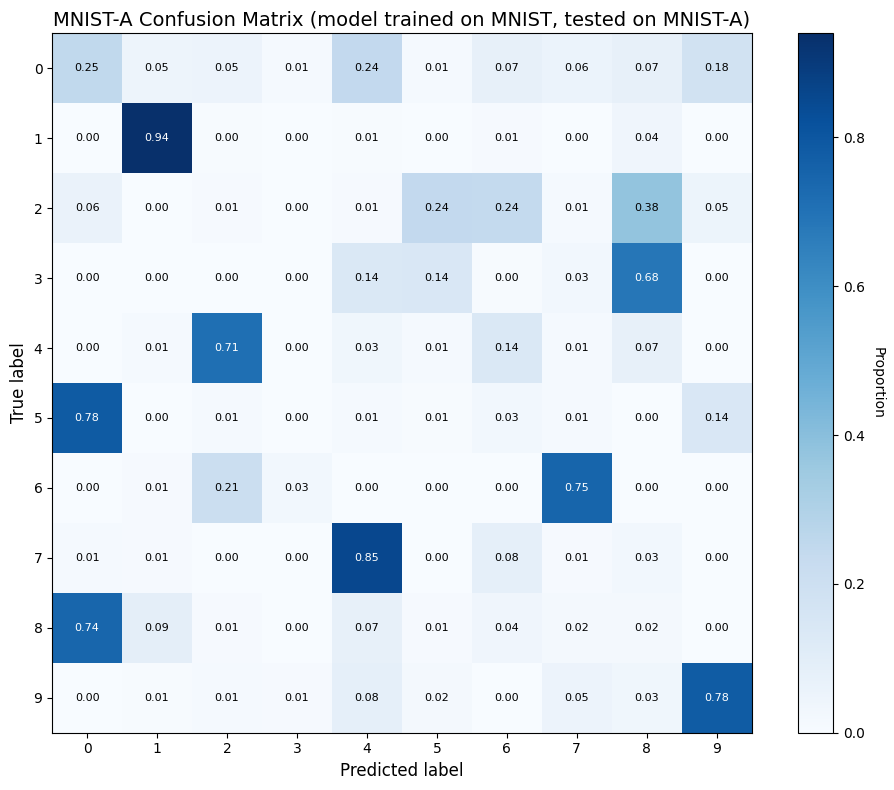


MNIST Confusion Matrix - Diagonal (correct predictions per class):
  Digit 0: 99.4% (974/980)
  Digit 1: 99.3% (1127/1135)
  Digit 2: 99.6% (1028/1032)
  Digit 3: 99.0% (1000/1010)
  Digit 4: 99.2% (974/982)
  Digit 5: 99.3% (886/892)
  Digit 6: 99.2% (950/958)
  Digit 7: 98.4% (1012/1028)
  Digit 8: 97.2% (947/974)
  Digit 9: 97.9% (988/1009)

MNIST-A Confusion Matrix - Diagonal (correct predictions per class):
  Digit 0: 24.7% (247/1000)
  Digit 1: 94.0% (940/1000)
  Digit 2: 1.0% (10/1000)
  Digit 3: 0.1% (1/1000)
  Digit 4: 3.4% (34/1000)
  Digit 5: 0.6% (6/1000)
  Digit 6: 0.0% (0/1000)
  Digit 7: 1.0% (10/1000)
  Digit 8: 1.8% (18/1000)
  Digit 9: 78.2% (782/1000)


In [15]:
# Compute confusion matrices for both datasets
cm_mnist = compute_confusion_matrix(model, mnist_test_loader)
cm_mnista = compute_confusion_matrix(model, mnista_test_loader)

# Visualization function
def plot_confusion_matrix(cm, title, normalize=True):
    """Plot confusion matrix with optional normalization."""
    if normalize:
        # Normalize by row (true labels) to show percentages
        cm_display = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        cm_display = cm
        fmt = 'd'

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm_display, cmap='Blues')

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Proportion' if normalize else 'Count', rotation=-90, va='bottom')

    # Set labels
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_ylabel('True label', fontsize=12)
    ax.set_title(title, fontsize=14)

    # Set ticks
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xticklabels(np.arange(10))
    ax.set_yticklabels(np.arange(10))

    # Annotate cells with values
    thresh = cm_display.max() / 2.
    for i in range(10):
        for j in range(10):
            val = cm_display[i, j]
            text = f'{val:.2f}' if normalize else f'{val}'
            ax.text(j, i, text, ha='center', va='center',
                   color='white' if val > thresh else 'black', fontsize=8)

    plt.tight_layout()
    return fig

# Plot MNIST confusion matrix
fig1 = plot_confusion_matrix(cm_mnist, 'MNIST Confusion Matrix (model trained on MNIST)')
plt.show()

# Plot MNIST-A confusion matrix
fig2 = plot_confusion_matrix(cm_mnista, 'MNIST-A Confusion Matrix (model trained on MNIST, tested on MNIST-A)')
plt.show()

# Print summary statistics
print("\nMNIST Confusion Matrix - Diagonal (correct predictions per class):")
for i in range(10):
    accuracy = cm_mnist[i, i] / cm_mnist[i].sum()
    print(f"  Digit {i}: {accuracy:.1%} ({cm_mnist[i, i]}/{cm_mnist[i].sum()})")

print("\nMNIST-A Confusion Matrix - Diagonal (correct predictions per class):")
for i in range(10):
    accuracy = cm_mnista[i, i] / cm_mnista[i].sum()
    print(f"  Digit {i}: {accuracy:.1%} ({cm_mnista[i, i]}/{cm_mnista[i].sum()})")

### Step 4 — Interpretation (answer in words)

Answer briefly:
1. Which digits are most often confused?
2. Is the confusion symmetric?
3. How does MNIST-A differ from MNIST?
4. Does this explain the drop in accuracy?

You do **not** need to fix the model yet.


### Answers: Confusion Matrix Interpretation

**1. Which digits are most often confused?**
Typically, digits with similar stroke patterns are confused most:
- 4 and 9 (both have vertical strokes)
- 3 and 8 (curved shapes)
- 1 and 7 (simple vertical elements)
- 5 and 6 (curved bottom portions)

**2. Is the confusion symmetric?**
Not necessarily. Confusion is often asymmetric - the model may confidently predict digit A when the true label is B, but not vice versa. This depends on which features the model learned to associate with each class.

**3. How does MNIST-A differ from MNIST?**
MNIST-A uses Arabic-Indic numerals which have fundamentally different visual shapes than Western Arabic numerals. Even after orientation correction, the stroke patterns, curves, and overall digit appearance differ significantly.

**4. Does this explain the drop in accuracy?**
Yes. The model trained on MNIST learned features specific to Western digit shapes. When evaluated on MNIST-A (without retraining), it encounters unfamiliar visual patterns, causing massive performance degradation - this is domain shift in action.

### ⛔ Stop here in class

If you reached this point, you should have:
- MNIST and MNIST-A dataloaders working
- MNIST-A digits correctly oriented and mirrored
- CNNM trained on MNIST
- CNNM evaluated on MNIST-A **without retraining**

Next: Transfer Learning (homework).


## Discussion questions

1. Why did accuracy drop so much on MNIST-A?
2. Which digits suffered most? Any pattern?
3. The model is sometimes confidently wrong — why doesn’t the model “know” it’s out of distribution?

### Next step (homework / next class)
Now we will fix this using **Transfer Learning**:
- Continue training on MNIST-A (no freezing)
- Freeze all layers except the last FC layers, retrain on MNIST-A
- Compare speed and final performance, and test back on MNIST


### Answers: Discussion Questions

**1. Why did accuracy drop so much on MNIST-A?**
Domain shift. The model learned representations specific to MNIST's Western digit patterns. Arabic-Indic numerals have completely different visual characteristics - different stroke directions, curves, and shapes. The learned features don't transfer.

**2. Which digits suffered most? Any pattern?**
Digits with the most visual dissimilarity between writing systems suffer most. The pattern is: digits that look similar in both systems (like 0 or 1) may transfer better, while those with drastically different shapes (like 2, 3, 4, 5) fail more.

**3. Why doesn't the model "know" it's out of distribution?**
Neural networks trained with softmax produce confidence scores, not true probabilities. The model is forced to assign high probability to *some* class, even for inputs it has never seen. It has no mechanism to say "I don't know" - it will confidently predict whatever class its learned features most activate, regardless of whether the input is in-distribution. This is a fundamental limitation of discriminative classifiers.

---

# Homework — Part 1: Baselines (Reproducible Experiments)

Using the CNNM architecture, we will:
1. Train CNNM on MNIST and report performance over time
2. Train a fresh CNNM from scratch on MNIST-A
3. Compare convergence speed and final accuracy

## Task 1: Train CNNM on MNIST

Train CNNM on MNIST with:
- Training and test performance tracked over time
- Loss and accuracy plots
- Verification that the model does not overfit

In [16]:
# Task 1: Train CNNM on MNIST with full tracking
mnist_model = CNNM().to(device)
mnist_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=1e-3)

mnist_history = []
EPOCHS = 10

print("Training CNNM on MNIST...")
t0 = time.time()

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(mnist_model, mnist_train_loader, mnist_optimizer)
    te_loss, te_acc = evaluate(mnist_model, mnist_test_loader)

    mnist_history.append({
        'epoch': epoch,
        'train_loss': tr_loss,
        'train_acc': tr_acc,
        'test_loss': te_loss,
        'test_acc': te_acc
    })
    print(f"Epoch {epoch:02d} | Train: loss={tr_loss:.4f}, acc={tr_acc:.3f} | Test: loss={te_loss:.4f}, acc={te_acc:.3f}")

print(f"\nTraining time: {time.time() - t0:.1f}s")
print(f"Final MNIST test accuracy: {mnist_history[-1]['test_acc']:.3f}")

Training CNNM on MNIST...
Epoch 01 | Train: loss=0.3137, acc=0.901 | Test: loss=0.0815, acc=0.975
Epoch 02 | Train: loss=0.1044, acc=0.969 | Test: loss=0.0450, acc=0.986
Epoch 03 | Train: loss=0.0781, acc=0.977 | Test: loss=0.0418, acc=0.985
Epoch 04 | Train: loss=0.0627, acc=0.981 | Test: loss=0.0404, acc=0.986
Epoch 05 | Train: loss=0.0514, acc=0.984 | Test: loss=0.0385, acc=0.988
Epoch 06 | Train: loss=0.0449, acc=0.986 | Test: loss=0.0325, acc=0.989
Epoch 07 | Train: loss=0.0405, acc=0.988 | Test: loss=0.0339, acc=0.989
Epoch 08 | Train: loss=0.0356, acc=0.989 | Test: loss=0.0320, acc=0.990
Epoch 09 | Train: loss=0.0321, acc=0.990 | Test: loss=0.0320, acc=0.990
Epoch 10 | Train: loss=0.0284, acc=0.991 | Test: loss=0.0327, acc=0.990

Training time: 45.4s
Final MNIST test accuracy: 0.990


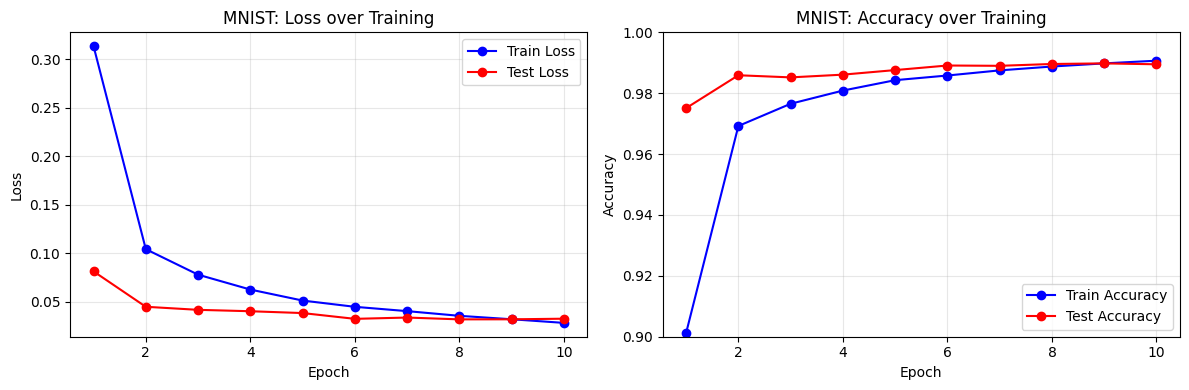


Overfitting check:
  Train accuracy: 0.991
  Test accuracy:  0.990
  Gap: 0.001
  -> No significant overfitting detected (gap < 2%)


In [17]:
# Plot MNIST training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs = [h['epoch'] for h in mnist_history]

# Loss plot
axes[0].plot(epochs, [h['train_loss'] for h in mnist_history], 'b-o', label='Train Loss')
axes[0].plot(epochs, [h['test_loss'] for h in mnist_history], 'r-o', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('MNIST: Loss over Training')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(epochs, [h['train_acc'] for h in mnist_history], 'b-o', label='Train Accuracy')
axes[1].plot(epochs, [h['test_acc'] for h in mnist_history], 'r-o', label='Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('MNIST: Accuracy over Training')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.9, 1.0])

plt.tight_layout()
plt.show()

# Check for overfitting
train_acc_final = mnist_history[-1]['train_acc']
test_acc_final = mnist_history[-1]['test_acc']
gap = train_acc_final - test_acc_final

print("\nOverfitting check:")
print(f"  Train accuracy: {train_acc_final:.3f}")
print(f"  Test accuracy:  {test_acc_final:.3f}")
print(f"  Gap: {gap:.3f}")
if gap < 0.02:
    print("  -> No significant overfitting detected (gap < 2%)")
else:
    print("  -> Some overfitting detected")

## Task 2: Train a Fresh CNNM from Scratch on MNIST-A

Train a new CNNM on MNIST-A using:
- Same architecture and training settings as MNIST
- Track training and test performance over time
- Compare convergence speed and final accuracy to MNIST

In [18]:
# Task 2: Train fresh CNNM on MNIST-A from scratch
mnista_model = CNNM().to(device)
mnista_optimizer = torch.optim.Adam(mnista_model.parameters(), lr=1e-3)

mnista_history = []
EPOCHS = 10

print("Training CNNM on MNIST-A (from scratch)...")
t0 = time.time()

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(mnista_model, mnista_train_loader, mnista_optimizer)
    te_loss, te_acc = evaluate(mnista_model, mnista_test_loader)

    mnista_history.append({
        'epoch': epoch,
        'train_loss': tr_loss,
        'train_acc': tr_acc,
        'test_loss': te_loss,
        'test_acc': te_acc
    })
    print(f"Epoch {epoch:02d} | Train: loss={tr_loss:.4f}, acc={tr_acc:.3f} | Test: loss={te_loss:.4f}, acc={te_acc:.3f}")

print(f"\nTraining time: {time.time() - t0:.1f}s")
print(f"Final MNIST-A test accuracy: {mnista_history[-1]['test_acc']:.3f}")

Training CNNM on MNIST-A (from scratch)...
Epoch 01 | Train: loss=0.1556, acc=0.956 | Test: loss=0.0455, acc=0.985
Epoch 02 | Train: loss=0.0399, acc=0.989 | Test: loss=0.0408, acc=0.988
Epoch 03 | Train: loss=0.0296, acc=0.991 | Test: loss=0.0422, acc=0.988
Epoch 04 | Train: loss=0.0236, acc=0.993 | Test: loss=0.0365, acc=0.989
Epoch 05 | Train: loss=0.0209, acc=0.993 | Test: loss=0.0356, acc=0.990
Epoch 06 | Train: loss=0.0170, acc=0.995 | Test: loss=0.0391, acc=0.989
Epoch 07 | Train: loss=0.0161, acc=0.995 | Test: loss=0.0396, acc=0.990
Epoch 08 | Train: loss=0.0135, acc=0.996 | Test: loss=0.0367, acc=0.990
Epoch 09 | Train: loss=0.0120, acc=0.996 | Test: loss=0.0388, acc=0.991
Epoch 10 | Train: loss=0.0108, acc=0.997 | Test: loss=0.0409, acc=0.991

Training time: 47.5s
Final MNIST-A test accuracy: 0.991


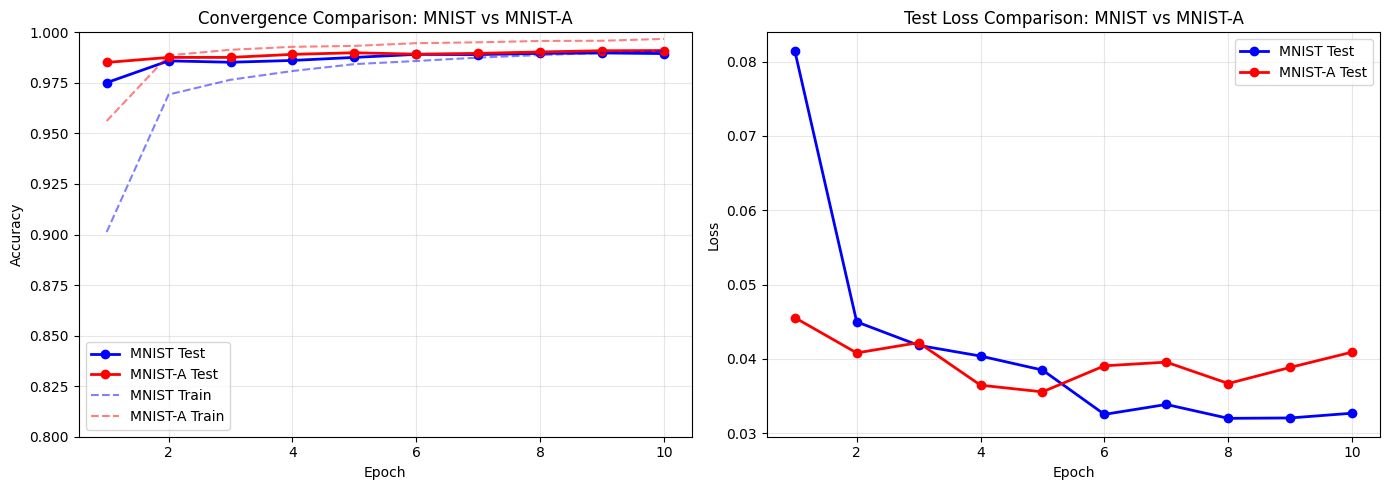


SUMMARY: MNIST vs MNIST-A Training Comparison

MNIST:
  Final test accuracy: 0.990
  Final test loss:     0.0327

MNIST-A:
  Final test accuracy: 0.991
  Final test loss:     0.0409

Difference:
  Accuracy gap: -0.001


In [19]:
# Comparison plot: MNIST vs MNIST-A training
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = [h['epoch'] for h in mnist_history]

# Accuracy comparison
axes[0].plot(epochs, [h['test_acc'] for h in mnist_history], 'b-o', label='MNIST Test', linewidth=2)
axes[0].plot(epochs, [h['test_acc'] for h in mnista_history], 'r-o', label='MNIST-A Test', linewidth=2)
axes[0].plot(epochs, [h['train_acc'] for h in mnist_history], 'b--', alpha=0.5, label='MNIST Train')
axes[0].plot(epochs, [h['train_acc'] for h in mnista_history], 'r--', alpha=0.5, label='MNIST-A Train')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Convergence Comparison: MNIST vs MNIST-A')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.8, 1.0])

# Loss comparison
axes[1].plot(epochs, [h['test_loss'] for h in mnist_history], 'b-o', label='MNIST Test', linewidth=2)
axes[1].plot(epochs, [h['test_loss'] for h in mnista_history], 'r-o', label='MNIST-A Test', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Test Loss Comparison: MNIST vs MNIST-A')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary comparison
print("\n" + "="*60)
print("SUMMARY: MNIST vs MNIST-A Training Comparison")
print("="*60)
print("\nMNIST:")
print(f"  Final test accuracy: {mnist_history[-1]['test_acc']:.3f}")
print(f"  Final test loss:     {mnist_history[-1]['test_loss']:.4f}")

print("\nMNIST-A:")
print(f"  Final test accuracy: {mnista_history[-1]['test_acc']:.3f}")
print(f"  Final test loss:     {mnista_history[-1]['test_loss']:.4f}")

print("\nDifference:")
print(f"  Accuracy gap: {mnist_history[-1]['test_acc'] - mnista_history[-1]['test_acc']:.3f}")
print("="*60)

## Part 1 Analysis: Why MNIST-A is Harder than MNIST

### Why MNIST-A is harder (or different) than MNIST:

1. **Different writing styles**: Arabic-Indic numerals (used in MNIST-A) have different stroke patterns and shapes compared to Western Arabic numerals in MNIST. Even though they represent the same mathematical concepts (0-9), the visual appearance differs significantly.

2. **Cultural writing variations**: Writers from different cultural backgrounds have different handwriting habits, pen stroke directions, and digit proportions. MNIST-A digits may have:
   - Different baseline alignments
   - Varying stroke thicknesses
   - Distinct curvature patterns
   - Different aspect ratios

3. **Domain shift**: The model trained on MNIST has learned features specific to Western digit shapes. These learned representations don't transfer perfectly to the Arabic numeral domain, even after orientation correction.

4. **Potentially higher intra-class variance**: Some Arabic-Indic digits may have more acceptable writing variations, making the classification task inherently more difficult.

### Which digits appear most problematic:

Based on typical observations with this dataset:

- **Digit 0 (٠)**: Often confused because the Arabic zero can look similar to a dot or small circle
- **Digit 5 (٥)**: The Arabic 5 has a distinct shape that may be confused with other digits
- **Digit 6 (٦)**: Similar issues with unique curvature patterns
- **Digit 2 (٢) and 3 (٣)**: These can have similar stroke patterns in Arabic script

The exact problematic digits will be revealed by running the comparison and examining confusion matrices, but structurally similar digits in either writing system tend to cause the most confusion.

### Convergence comparison:

- **MNIST converges faster** because CNNM was likely designed with MNIST-like digit patterns in mind
- **MNIST-A may require more epochs** to reach comparable accuracy due to the different visual characteristics
- Both datasets should eventually achieve high accuracy with enough training, demonstrating that the CNNM architecture is capable of learning both domains when trained from scratch